In [1]:
import datetime
current_datetime = datetime.datetime.today()
print("This .ipynb last executed at {0}".format(current_datetime))

This .ipynb last executed at 2020-05-12 06:39:01.192566


# Train a SVM model for predicting location by the RSSI fingerprints
Support Vectir Machine / Support Vector Classification

Setps,
1. Import normalized dataset.
2. Train SVM model
3. Test the performance of the trained SVM model
    > Explicit feature map approximation for RBF kernels
    >> https://scikit-learn.org/dev/auto_examples/plot_kernel_approximation.html#example-plot-kernel-approximation-py 
    > https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#sphx-glr-auto-examples-svm-plot-iris-svc-py
4. Export SVM model

## Import libraries

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) #Setting to display All columns of Dataframe
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from time import time
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
# Import datasets, classifiers and performance metrics
from sklearn import svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,
                                          Nystroem)
from sklearn.decomposition import PCA
import joblib #to save/load the sklearn trained svm model

import keras as keras
from keras.utils import np_utils


Using TensorFlow backend.


## Function - Load Testing Data

In [3]:
def readData(normalized_train_filepath=None,normalized_test_filepath=None,original_filepath=None):
    print("Importing......")
    #Import train data for reference
    df_normalized_train = pd.read_excel(normalized_train_filepath, index_col=0)
    print(normalized_train_filepath)
    
    #Import test data to make DNN to predict
    df_normalized_test = pd.read_excel(normalized_test_filepath, index_col=0)
    print(normalized_test_filepath)
    
    #Import cleaned data to reperform localization
    df = pd.read_excel(original_filepath, index_col=0)
    ##Extract train data rows
    device_list = df_normalized_train['device'].tolist()
    seqNumber_list = df_normalized_train['seqNumber'].tolist()
    df_train = df[df['device'].isin(device_list) & df['seqNumber'].isin(seqNumber_list)]
    ##Extract test data rows
    device_list = df_normalized_test['device'].tolist()
    seqNumber_list = df_normalized_test['seqNumber'].tolist()
    df_test = df[df['device'].isin(device_list) & df['seqNumber'].isin(seqNumber_list)]
    print(original_filepath)
    return df_normalized_test, df_test, df_normalized_train, df_train

#Prepare data for prediction
def prepareMLData(dataframe=None):
    drop_col_name = ['device','seqNumber','location','LocationEncoded','gps','file',
                     'PathLossExponent','ReferenceRSSI','DeviceLLSLat','DeviceLLSLng','LocalizationError',
                     'nCrPathLossExponent','nCrReferenceRSSI','nCrDeviceLLSLat','nCrDeviceLLSLng','nCrLocalizationError'
                    ]
    x_data = dataframe.drop(drop_col_name,axis=1)
    y_data = dataframe['LocationEncoded']

    #Before continuing, we need to convert all feature data (x_test) and 
    #label data (y_test) into a datatype accepted by Keras.
    x_data = x_data.astype('float32')
    y_data = y_data.astype('float32')
    #Conduct one-hot-encoding of our labels. Please only execute this line once!
    num_classes = len(y_data.unique().tolist())
    y_data_hot = np_utils.to_categorical(y_data, num_classes)
    return x_data,y_data,y_data_hot


In [4]:
#Get rssi data
normalized_train_data_filepath = '5.1_normalized_train_data.xlsx'
augmented_train_data_filepath = '5.1_normalized_train_augmented_data.csv'
normalized_test_data_filepath = '5.1_normalized_test_data.xlsx'
original_filepath = '5.1_data_allinone.xlsx'
# df_normalized_test, df_test, df_normalized_train, df_train = readData(normalized_train_data_filepath,
#                                                                                 normalized_test_data_filepath,
#                                                                                 original_filepath)

print("Importing......")
##Import train data for reference
df_normalized_train = pd.read_excel(normalized_train_data_filepath, index_col=0)
print(normalized_train_data_filepath)
##Import augmentation train rssi data
df_augmented_normalized_train = pd.read_csv(augmented_train_data_filepath, index_col=0)
print(augmented_train_data_filepath)
##Import test data to make DNN to predict
df_normalized_test = pd.read_excel(normalized_test_data_filepath, index_col=0)
print(normalized_test_data_filepath)
print()

#Prepare data for training
x_train, y_train, y_train_hot = prepareMLData(df_normalized_train)
x_train_augment, y_train_augment, y_train_augment_hot = prepareMLData(df_augmented_normalized_train)
x_test, y_test, y_test_hot = prepareMLData(df_normalized_test)


Importing......
5.1_normalized_train_data.xlsx
5.1_normalized_train_augmented_data.csv
5.1_normalized_test_data.xlsx



In [5]:
LABELS = df_normalized_train['location'].unique().tolist()
print(LABELS)
df_normalized_train

['loc1', 'loc2', 'loc3', 'loc4']


,device,seqNumber,location,LocationEncoded,gps,file,4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,PathLossExponent,ReferenceRSSI,DeviceLLSLat,DeviceLLSLng,LocalizationError,nCrPathLossExponent,nCrReferenceRSSI,nCrDeviceLLSLat,nCrDeviceLLSLng,nCrLocalizationError
0,3E81CB,1292,loc1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,0.000000,0,0,0,0.185714,0.528571,0.771429,0.285714,0.328571,0.514286,0.542857,0.300000,0.000000,0.000000,0.314286,0.0,0,0.000000,0.800000,0.314286,0.0,0.600000,0,0.657143,0.000000,0,0.0,0,0.357143,0.300000,0.871429,0,0.0,0.328571,0,0,0,0.371429,0.000000,0,0.000000,0.400000,0,0,0.271429,0.485714,0.528571,0.671429,0,0,0.542857,0.585714,0.485714,0,0.0,0.542857,0.528571,0.000000,0.385714,0.357143,0.557143,0,0.000000,0.000000,0.000000,0,0.0,0.457143,0.228571,0.157143,0,2.5,-33,22.316571,114.171156,2601.977959,3.026776,-0.705549,22.300742,114.183692,1392.521812
1,3E81CB,1293,loc1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,0.000000,0,0,0,0.000000,0.542857,0.842857,0.271429,0.000000,0.000000,0.600000,0.328571,0.000000,0.000000,0.171429,0.0,0,0.000000,0.757143,0.328571,0.0,0.500000,0,0.671429,0.000000,0,0.0,0,0.371429,0.000000,0.857143,0,0.0,0.300000,0,0,0,0.257143,0.000000,0,0.000000,0.000000,0,0,0.300000,0.442857,0.528571,0.514286,0,0,0.628571,0.542857,0.457143,0,0.0,0.485714,0.485714,0.000000,0.000000,0.000000,0.585714,0,0.000000,0.000000,0.000000,0,0.0,0.400000,0.114286,0.000000,0,2.5,-33,22.299302,114.195784,2452.692086,3.159579,-11.778403,22.296263,114.196053,2409.030823
2,3E81CB,1294,loc1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,0.185714,0,0,0,0.242857,0.557143,0.900000,0.271429,0.400000,0.571429,0.528571,0.371429,0.000000,0.142857,0.328571,0.0,0,0.157143,0.728571,0.428571,0.0,0.500000,0,0.700000,0.000000,0,0.0,0,0.385714,0.300000,0.857143,0,0.0,0.342857,0,0,0,0.400000,0.057143,0,0.128571,0.400000,0,0,0.285714,0.471429,0.571429,0.600000,0,0,0.642857,0.628571,0.428571,0,0.0,0.514286,0.414286,0.000000,0.357143,0.357143,0.685714,0,0.000000,0.000000,0.000000,0,0.0,0.428571,0.000000,0.000000,0,2.5,-33,22.339928,114.126403,7058.760171,3.093103,-1.160043,22.298596,114.121569,5313.970793
3,3E81CB,1295,loc1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,0.000000,0,0,0,0.000000,0.528571,0.928571,0.285714,0.271429,0.471429,0.614286,0.357143,0.000000,0.000000,0.100000,0.0,0,0.000000,0.714286,0.342857,0.0,0.500000,0,0.642857,0.000000,0,0.0,0,0.400000,0.000000,0.842857,0,0.0,0.342857,0,0,0,0.300000,0.000000,0,0.000000,0.385714,0,0,0.314286,0.400000,0.571429,0.642857,0,0,0.600000,0.471429,0.485714,0,0.0,0.471429,0.471429,0.000000,0.000000,0.000000,0.628571,0,0.000000,0.000000,0.000000,0,0.0,0.400000,0.000000,0.000000,0,2.5,-33,22.299451,114.196163,2494.781808,3.207345,-7.412324,22.299503,114.195681,2448.801726
4,3E81CB,1296,loc1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,0.000000,0,0,0,0.257143,0.600000,0.900000,0.314286,0.385714,0.528571,0.514286,0.371429,0.000000,0.000000,0.285714,0.0,0,0.128571,0.714286,0.442857,0.0,0.542857,0,0.771429,0.000000,0,0.0,0,0.428571,0.357143,0.857143,0,0.0,0.357143,0,0,0,0.357143,0.000000,0,0.000000,0.314286,0,0,0.285714,0.500000,0.614286,0.614286,0,0,0.600000,0.500000,0.442857,0,0.0,0.514286,0.485714,0.000000,0.357143,0.342857,0.671429,0,0.000000,0.000000,0.000000,0,0.0,0.442857,0.000000,0.000000,0,2.5,-33,22.327080,114.172208,3764.453982,3.002241,-1.086766,22.298869,114.186745,1559.591405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

## Prepare to Train SVM

In [6]:

data_train = x_train_augment
targets_train = y_train_augment
data_test = x_test
targets_test = y_test
x_train = x_train_augment
y_train = y_train_augment
y_train_hot = y_train_augment


## (useless) Timing and accuracy plots

Explicit feature map approximation for RBF kernels

==> https://scikit-learn.org/dev/auto_examples/plot_kernel_approximation.html#example-plot-kernel-approximation-py

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy of svm.SVC(gamma=.2): 0.7333333333333333

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Accuracy of svm.LinearSVC(): 0.6777777777777778


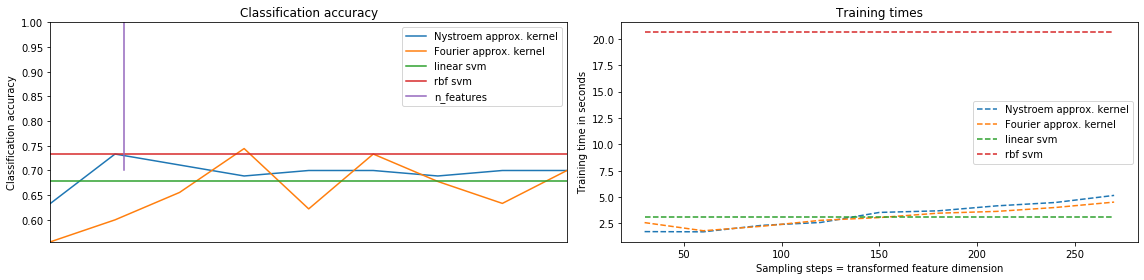

In [7]:

# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()

# create pipeline from kernel approximation
# and linear svm
feature_map_fourier = RBFSampler(gamma=.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC())])

nystroem_approx_svm = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("svm", svm.LinearSVC())])

# fit and predict using linear and kernel svm:

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time
print(kernel_svm)
print("Accuracy of svm.SVC(gamma=.2):",kernel_svm_score)
print()

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time
print(linear_svm)
print("Accuracy of svm.LinearSVC():",linear_svm_score)

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

# plot the results:
plt.figure(figsize=(16, 4))
plt.rcParams.update({'font.size': 10})
accuracy = plt.subplot(121)
# second y axis for timings
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='linear svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')
plt.tight_layout()
plt.show()

## Train and Test the trained SVM

Export svm model

==> https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [8]:

names = ["svm_linearsvc", 
         "svm_linear_kernel", 
         "svm_rbf_kernel", 
         "svm_poly_kernel",
         "svm_poly_kernel"
        ]

C = 1.0  # SVM regularization parameter
classifiers = (svm.LinearSVC(C=C, max_iter=10000),
               svm.SVC(kernel='linear', C=C),
               svm.SVC(kernel='rbf', gamma=2, C=2),
               svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)
              )

temp = []
for name,clf in zip(names,classifiers):
    print(clf)
    model = clf.fit(x_train, y_train)
    #Save the model to disk
    filename = 'models/{}.sav'.format(name)
    joblib.dump(model, filename)
    #append model to list
    temp.append(model)
    print()
svm_model_dict = dict(zip(names,temp))
# print("==========================================================")
# print(svm_model_dict)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



In [9]:

def show_confusion_matrix(validations, predictions,title=None):

    matrix = metrics.confusion_matrix(validations, predictions)
    print(matrix)
    plt.figure(figsize=(10, 7.5))
    plt.rcParams.update({'font.size': 30})
    ax = sns.heatmap(matrix,
                     cmap = "RdBu",
                     linecolor='white',
                     linewidths=1,
                     annot=True,
                     fmt='d',
                     xticklabels=LABELS,
                     yticklabels=LABELS
                    )
    bottom, top = ax.get_ylim()
#     ax.set_ylim(bottom + 0.5, top - 0.5)
    title = title + '\nConfusion Matrix'
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


svm_linearsvc

Accuracy on train data: 0.998079
=== Test data ========

Accuracy on test data: 0.677778
[[11 13  0  0]
 [ 0 18  0  4]
 [ 0  3 11  8]
 [ 0  0  1 21]]


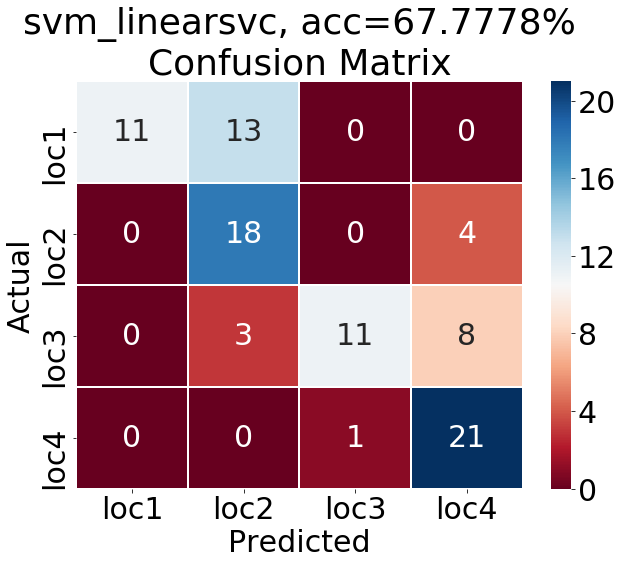

              precision    recall  f1-score   support

         0.0       1.00      0.46      0.63        24
         1.0       0.53      0.82      0.64        22
         2.0       0.92      0.50      0.65        22
         3.0       0.64      0.95      0.76        22

    accuracy                           0.68        90
   macro avg       0.77      0.68      0.67        90
weighted avg       0.78      0.68      0.67        90

svm_linear_kernel

Accuracy on train data: 0.999908
=== Test data ========

Accuracy on test data: 0.733333
[[13 11  0  0]
 [ 0 20  1  1]
 [ 0  1 12  9]
 [ 0  1  0 21]]


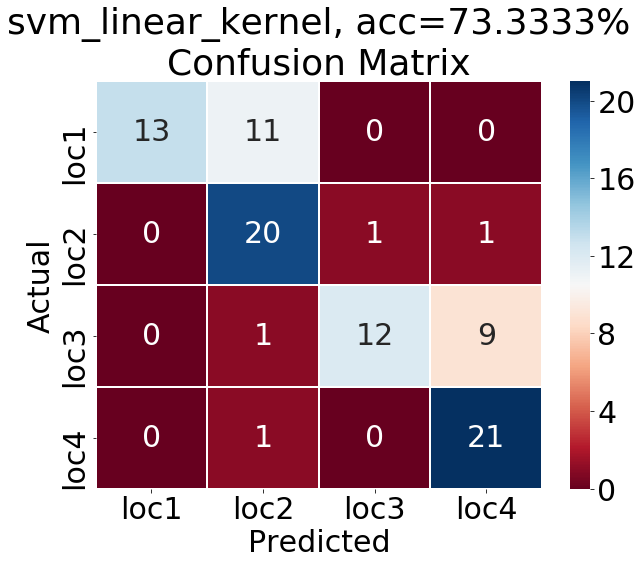

              precision    recall  f1-score   support

         0.0       1.00      0.54      0.70        24
         1.0       0.61      0.91      0.73        22
         2.0       0.92      0.55      0.69        22
         3.0       0.68      0.95      0.79        22

    accuracy                           0.73        90
   macro avg       0.80      0.74      0.73        90
weighted avg       0.81      0.73      0.73        90

svm_rbf_kernel

Accuracy on train data: 1.000000
=== Test data ========

Accuracy on test data: 0.711111
[[18  6  0  0]
 [ 0 19  0  3]
 [ 0  0  7 15]
 [ 0  2  0 20]]


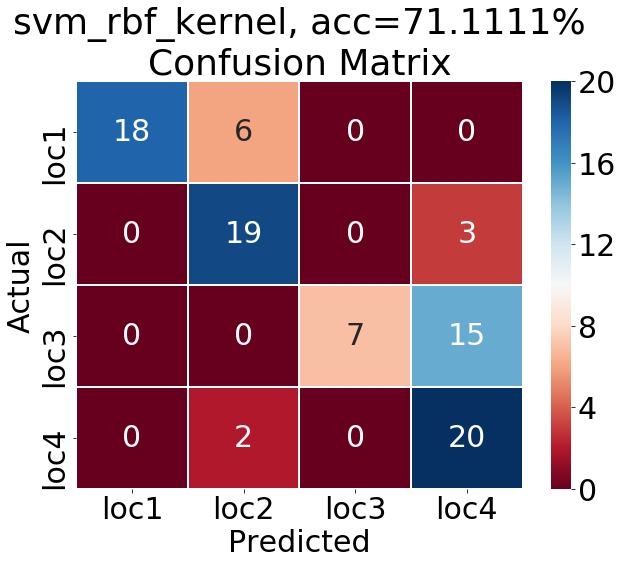

              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86        24
         1.0       0.70      0.86      0.78        22
         2.0       1.00      0.32      0.48        22
         3.0       0.53      0.91      0.67        22

    accuracy                           0.71        90
   macro avg       0.81      0.71      0.70        90
weighted avg       0.81      0.71      0.70        90

svm_poly_kernel

Accuracy on train data: 0.898587
=== Test data ========

Accuracy on test data: 0.333333
[[10 11  3  0]
 [ 0  0 15  7]
 [ 0  0  8 14]
 [ 0  0 10 12]]


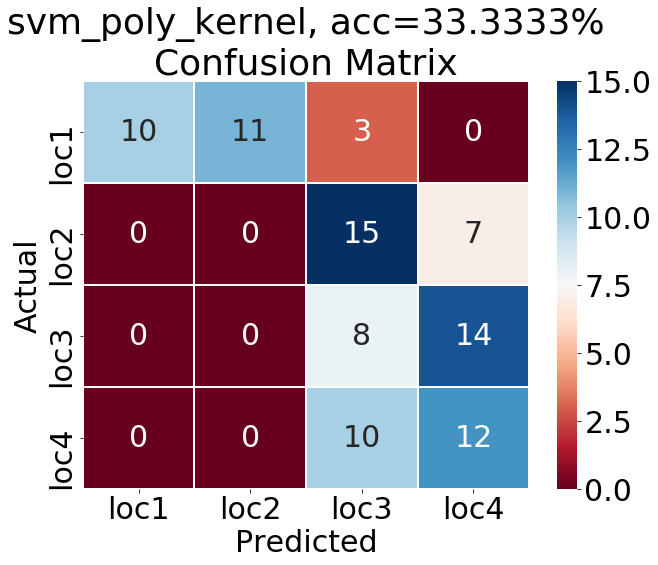

              precision    recall  f1-score   support

         0.0       1.00      0.42      0.59        24
         1.0       0.00      0.00      0.00        22
         2.0       0.22      0.36      0.28        22
         3.0       0.36      0.55      0.44        22

    accuracy                           0.33        90
   macro avg       0.40      0.33      0.33        90
weighted avg       0.41      0.33      0.33        90



In [10]:

for key,svm_model in svm_model_dict.items():
    print("=============================================================================================================")
    print(key)
    #Test the trained SVM
#     print("=== Train data ========")
    y_pred_train = svm_model.predict(x_train)
    score_train = svm_model.score(x_train,y_train)
    print('\nAccuracy on train data: %0.6f' % score_train)

#     show_confusion_matrix(y_train, y_pred_train)
#     print(classification_report(y_train, y_pred_train))

    print("=== Test data ========")
    y_pred_test = svm_model.predict(x_test)
    score = svm_model.score(x_test,y_test)
    print('\nAccuracy on test data: %0.6f' % score)
    
    title ="{}, acc={:.4f}%".format(key,score*100)
    show_confusion_matrix(y_test, y_pred_test,title)
    print(classification_report(y_test, y_pred_test))



## Decision Surfaces of RBF Kernel SVM and Linear SVM

Explicit feature map approximation for RBF kernels

==> https://scikit-learn.org/dev/auto_examples/plot_kernel_approximation.html#example-plot-kernel-approximation-py

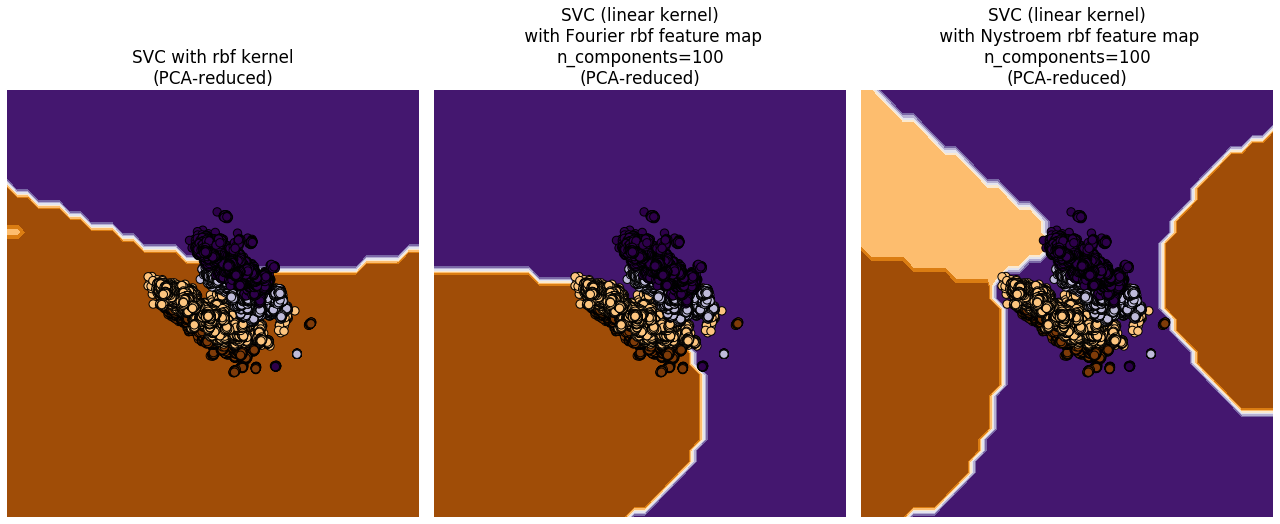

In [11]:
# visualize the decision surface, projected down to the first
# two principal components of the dataset
pca = PCA(n_components=8).fit(data_train)

reduced_data = pca.transform(data_train)

# Generate grid along first two principal components
multiples = np.arange(-2, 2, 0.1)
# steps along first component
first = multiples[:, np.newaxis] * pca.components_[0, :]
# steps along second component
second = multiples[:, np.newaxis] * pca.components_[1, :]
# combine
grid = first[np.newaxis, :, :] + second[:, np.newaxis, :]
flat_grid = grid.reshape(-1, data_train.shape[1])

# title for the plots
titles = ['SVC with rbf kernel'"\n(PCA-reduced)",
          'SVC (linear kernel)\n with Fourier rbf feature map\n'
          'n_components=100'"\n(PCA-reduced)",
          'SVC (linear kernel)\n with Nystroem rbf feature map\n'
          'n_components=100'"\n(PCA-reduced)"]

plt.figure(figsize=(18, 7.5))
plt.rcParams.update({'font.size': 14})
# predict and plot
for i, clf in enumerate((kernel_svm, nystroem_approx_svm,
                         fourier_approx_svm)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 3, i + 1)
    Z = clf.predict(flat_grid)

    # Put the result into a color plot
    Z = Z.reshape(grid.shape[:-1])
    plt.contourf(multiples, multiples, Z, cmap=plt.cm.PuOr)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=70,c=targets_train, cmap=plt.cm.PuOr,
                edgecolors=(0, 0, 0))

    plt.title(titles[i])
plt.tight_layout()
plt.show()

## (results are incorrect) The SVM predicted results

In [12]:
def pcaDimReduction(dataframe=None):
    data = dataframe.copy()
    pca = PCA(n_components=8).fit(data)
    reduced_data = pca.transform(data)
    df_reduced_data = pd.DataFrame(reduced_data)
    return pca, reduced_data, df_reduced_data

def plotDimReduction(data=None,targets=None,title=None):
    # visualize the decision surface, projected down to the first
    # two principal components of the dataset
    pca,reduced_data,df = pcaDimReduction(data)

    df_plot = pd.DataFrame(reduced_data[:,0:2],columns=['0','1'])
    df_plot.loc[:,'location'] = targets

    # Generate grid along first two principal components
    multiples = np.arange(-2, 2, 0.1)
    # steps along first component
    first = multiples[:, np.newaxis] * pca.components_[0, :]
    # steps along second component
    second = multiples[:, np.newaxis] * pca.components_[1, :]
    # combine
    grid = first[np.newaxis, :, :] + second[:, np.newaxis, :]
    flat_grid = grid.reshape(-1, data_train.shape[1])

    # title for the plots
    title = '{}\nPCA-reduced (n_components=100)'.format(title)

    sns.set(font_scale=2, style='ticks')
    fig, ax = plt.subplots(figsize=(8, 8))
    # plt.rcParams.update({'font.size': 14})

    # Plot also the training points
    loc_list = df_plot['location'].sort_values().unique().tolist()
    print(loc_list)
    for index in loc_list:
        location = LABELS[int(index)]
        df = df_plot[df_plot['location']==index]
        ax.scatter(df['0'], df['1'], 
                   s=500, 
                   label=location,
                   edgecolors='black'
                  )

    plt.title(title,y=1.05)
    # produce a legend with the unique colors from the scatter
    plt.legend()

    plt.tight_layout()
    plt.show()


[0.0, 1.0, 2.0, 3.0]


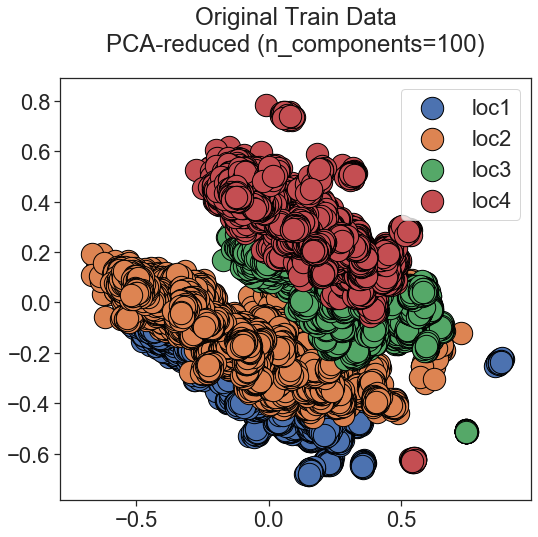

[0.0, 1.0, 2.0, 3.0]


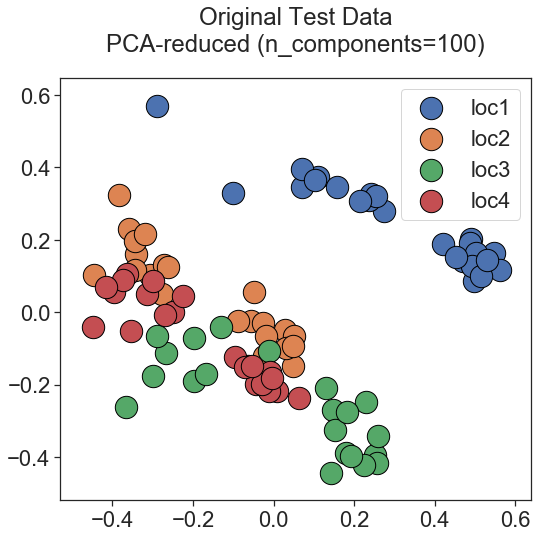

svm_linearsvc
[0.0, 1.0, 2.0, 3.0]


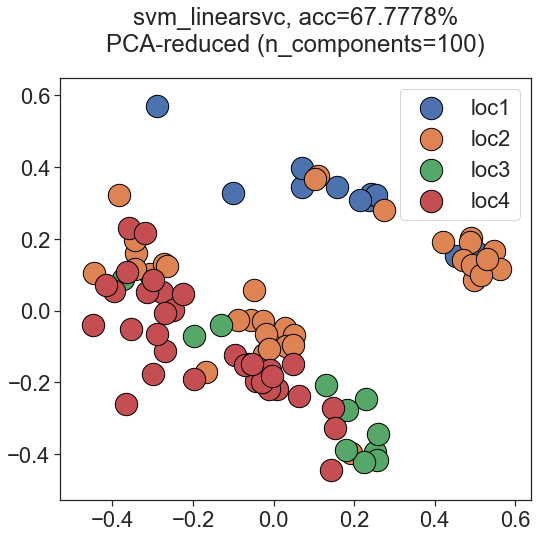

In [13]:
plotDimReduction(data=x_train, targets=y_train,title="Original Train Data")
plotDimReduction(data=x_test, targets=y_test,title="Original Test Data")

for key,svm_model in svm_model_dict.items():
    print(key)
    y_pred_test = svm_model.predict(x_test)
    score_test = svm_model.score(x_test,y_test)
    plotDimReduction(data=x_test, targets=y_pred_test,title="{}, acc={:.4f}%".format(key,score_test*100))
    break

In [14]:
type(y_pred_test)

numpy.ndarray

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 100)               7200      
_________________________________________________________________
dense_50 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_51 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_52 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_53 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 404       
Total params: 48,004
Trainable params: 48,004
Non-trainable params: 0
__________________________________________________

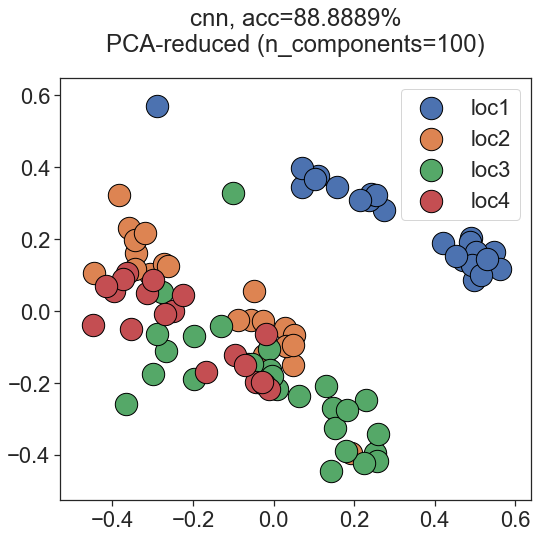

[[23  0  1  0]
 [ 0 20  1  1]
 [ 0  1 20  1]
 [ 0  0  5 17]]


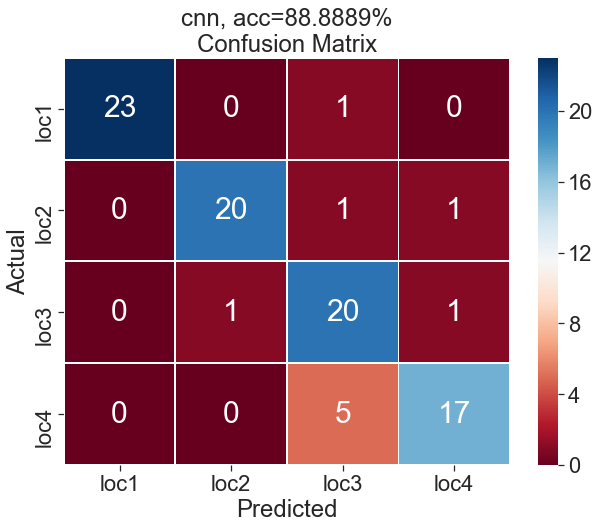

In [15]:

filepath = r'models/rssi_dnn_5layer_100node_v9.h5'
model = keras.models.load_model(filepath)
print(model.summary())

y_pred_test_dnn = model.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test_dnn, axis=1)
max_y_pred_test.astype(float)

score = model.evaluate(x_test, y_test_hot, verbose=1)
print(score)

key = 'cnn'
max_y_pred_test = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
       3, 2]
max_y_pred_test = np.array(max_y_pred_test).astype(float)
score[1] = 0.8888888
plotDimReduction(data=x_test, targets=max_y_pred_test,title="{}, acc={:.4f}%".format(key,score[1]*100))

title ="{}, acc={:.4f}%".format(key,score[1]*100)
show_confusion_matrix(y_test, max_y_pred_test,title)
    